In [14]:
!pip install networkx
!pip install Qiskit
!pip install qiskit_nature
!pip install qiskit_ignis
!pip install qiskit-ibm-runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import networkx as nx

from qiskit import  QuantumCircuit, QuantumRegister, transpile,IBMQ
from qiskit.circuit import ParameterVector
from qiskit.opflow import X, Z, I,Y


from qiskit_ibm_runtime import QiskitRuntimeService, Session,Estimator,Sampler
from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit.providers.aer import QasmSimulator, Aer
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator,
                                Sampler as RuntimeSampler,
                                Options)
from qiskit.primitives import Sampler,Estimator
from qiskit_aer.noise import NoiseModel


import util1

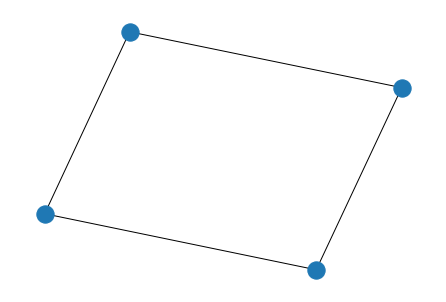

In [16]:
g = nx.Graph()
 
g.add_edge(0, 1)
g.add_edge(1, 2)
g.add_edge(2, 3)
g.add_edge(0, 3)

nx.draw(g)
plt.show()

In [17]:
from qiskit.opflow import X, Z, I,Y


def Ising_PBC_dual(g,h):
  E1 = Z^Z^I^I
  E2 = I^Z^Z^I
  E3 = I^I^Z^Z
  E4 = Z^I^I^Z
  B1 = X^I^I^I
  B2 = I^X^I^I
  B3 = I^I^X^I
  B4 = I^I^I^X


  H=(h*B1) + \
    (h*B2) + \
    (h*B3) + \
    (h*B4) + \
    (g*E1) + \
    (g*E2) + \
    (g*E3) + \
    (g*E4) 
  return H

In [30]:
g=1
h=1
edge_list=[[0,1],[1,2],[2,3],[0,3]]
initial_layout=[0,1,2,3]

In [36]:
def ansatz_ising(num_qubits,measure_list,depth):
  theta = ParameterVector("t",depth*(len(measure_list)+2*num_qubits))
  qr=QuantumRegister(num_qubits)
  circuit = QuantumCircuit(qr)
  index = 0

  circuit.x(qr[i] for i in range (0,num_qubits))
  circuit.h(qr[i] for i in range (0,num_qubits))
  for _ in range (0,depth): 
    for edge in measure_list:
      circuit.cx(qr[edge[1]],qr[edge[0]])
      circuit.rz(theta[index],qr[edge[0]])
      circuit.cx(qr[edge[1]],qr[edge[0]])
    index+=1
    circuit.barrier()
    for i in range (0,num_qubits):
      circuit.rx(theta[index], qr[i])
      index+=1
  #circuit=transpile(circuit,optimization_level=3,coupling_map=[[0,1],[1,2],[1,3]],basis_gates=['cx', 'id', 'rz', 'sx', 'x'])
  print(circuit.count_ops())
  return circuit

In [37]:
ansatz=ansatz_ising(4,edge_list,2)
ansatz.draw()

OrderedDict([('cx', 16), ('rz', 8), ('rx', 8), ('x', 4), ('h', 4), ('barrier', 2)])


┌───┐┌───┐┌───┐┌──────────┐┌───┐                           »
q5255_0: ┤ X ├┤ H ├┤ X ├┤ Rz(t[0]) ├┤ X ├───────────────────────────»
         ├───┤├───┤└─┬─┘└──────────┘└─┬─┘┌───┐┌──────────┐┌───┐     »
q5255_1: ┤ X ├┤ H ├──■────────────────■──┤ X ├┤ Rz(t[0]) ├┤ X ├─────»
         ├───┤├───┤                      └─┬─┘└──────────┘└─┬─┘┌───┐»
q5255_2: ┤ X ├┤ H ├────────────────────────■────────────────■──┤ X ├»
         ├───┤├───┤                                            └─┬─┘»
q5255_3: ┤ X ├┤ H ├──────────────────────────────────────────────■──»
         └───┘└───┘                                                 »
«                          ┌───┐┌──────────┐┌───┐ ░ ┌──────────┐┌───┐»
«q5255_0: ─────────────────┤ X ├┤ Rz(t[0]) ├┤ X ├─░─┤ Rx(t[1]) ├┤ X ├»
«                          └─┬─┘└──────────┘└─┬─┘ ░ ├──────────┤└─┬─┘»
«q5255_1: ───────────────────┼────────────────┼───░─┤ Rx(t[2]) ├──■──»
«         ┌──────────┐┌───┐  │                │   ░ ├──────────┤     »
«q5255_2: ┤ Rz(t[0]) ├┤ X ├──┼────────────────┼───░─┤ Rx(t[3]) ├─────»
«         └──────────┘└─┬─┘  │                │   ░ ├──────────┤     »
«q5255_3: ──────────────■────■────────────────■───░─┤ Rx(t[4]) ├─────»
«                                                 ░ └──────────┘     »
«         ┌──────────┐┌───┐                                            ┌───┐»
«q5255_0: ┤ Rz(t[5]) ├┤ X ├────────────────────────────────────────────┤ X ├»
«         └──────────┘└─┬─┘┌───┐┌──────────┐┌───┐                      └─┬─┘»
«q5255_1: ──────────────■──┤ X ├┤ Rz(t[5]) ├┤ X ├────────────────────────┼──»
«                          └─┬─┘└──────────┘└─┬─┘┌───┐┌──────────┐┌───┐  │  »
«q5255_2: ───────────────────■────────────────■──┤ X ├┤ Rz(t[5]) ├┤ X ├──┼──»
«                                                └─┬─┘└──────────┘└─┬─┘  │  »
«q5255_3: ─────────────────────────────────────────■────────────────■────■──»
«                                                                           »
«         ┌──────────┐┌───┐ ░ ┌──────────┐
«q5255_0: ┤ Rz(t[5]) ├┤ X ├─░─┤ Rx(t[6]) ├
«         └──────────┘└─┬─┘ ░ ├──────────┤
«q5255_1: ──────────────┼───░─┤ Rx(t[7]) ├
«                       │   ░ ├──────────┤
«q5255_2: ──────────────┼───░─┤ Rx(t[8]) ├
«                       │   ░ ├──────────┤
«q5255_3: ──────────────■───░─┤ Rx(t[9]) ├
«                           ░ └──────────┘

In [21]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=20)
exact_result = exact_solver.compute_eigenvalues(Ising_PBC_dual(1,1))
print(exact_result.eigenvalues)


# Save ground state energy for later
gs_energy_ising= np.round(exact_result.eigenvalues[0], 4)

[-5.22625186e+00 -4.82842712e+00 -2.16478440e+00 -2.00000000e+00
 -2.00000000e+00 -8.28427125e-01 -6.84056945e-16 -3.65274385e-16
 -1.73512519e-16  5.71096730e-17  8.28427125e-01  2.00000000e+00
  2.00000000e+00  2.16478440e+00  4.82842712e+00  5.22625186e+00]


In [22]:
from qiskit.algorithms.optimizers import SPSA,COBYLA,L_BFGS_B,SLSQP,NFT

spsa = SPSA(maxiter=5,blocking=False, allowed_increase=1, trust_region=False,
                 learning_rate=None, perturbation=None, last_avg=10, resamplings=0,
                 perturbation_dims=None, second_order=False, regularization=None, 
                 hessian_delay=0, lse_solver=None, initial_hessian=None, callback=None,
                 termination_checker=None)

cobyla=COBYLA(maxiter=100, disp=True, rhobeg=1.0, tol=1e-7, options=None)
slsqp=SLSQP(maxiter=100, disp=False, ftol=1e-06, tol=None, eps=1.4901161193847656e-08, options=None, max_evals_grouped=1)
nft=NFT(maxiter=50, maxfev=1024, disp=True, reset_interval=100, options=None)

In [23]:

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class Miti_CustomVQE(MinimumEigensolver):
    
    def __init__(self, sampler, circuit, optimizer,level_miti,callback=None):
        self._sampler = sampler
        self._circuit = circuit
        self._optimizer = optimizer
        self._level_miti=level_miti
        self._callback = callback
        
    def compute_minimum_eigenvalue(self,ham):
                
        # Define objective function to classically minimize over
        def objective(x):
            energy=0
            qc_cal_bound=transpile(self._circuit.assign_parameters(x),basis_gates=['cx', 'id', 'rz', 'sx', 'x'],optimization_level=0)
            energy_mean,energy_error=util1.miti_estimator(qc_cal_bound,ham,self._sampler,shots=10000,level_miti=self._level_miti)
            energy_mean=energy_mean.real
            energy_error=energy_error.real
            print('miti_sampler')
            print(energy_mean,energy_error)
            estimator_ideal = Estimator([self._circuit], [ham])
            job = estimator_ideal.run([self._circuit], [ham], [x])
            est_result = job.result()
            print('ideal_energy')
            print(est_result.values[0])

            if self._callback is not None:
                data=[energy_mean,energy_error,est_result.values[0],x]
                self._callback(data)  
            return energy_mean
            
        # Select an initial point for the ansatzs' parameters

       # Select an initial point for the ansatzs' parameters
        #x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        x0 = np.ones(self._circuit.num_parameters)*np.pi/4
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [24]:


# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            estimator_ideal = Estimator([self._circuit], [operators])
            job = estimator_ideal.run([self._circuit], [operators], [x])
            ideal_result = job.result().values[0]
            print('ideal_energy')
            print(ideal_result)

            # Save result information using callback function
            if self._callback is not None:

                self._callback([value,ideal_result,x])
                print('miti_energy')
                print(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        #x0 = np.ones(self._circuit.num_parameters)*np.pi/4
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

miti_sampler
-3.9647599999999996 0.07481236392414271
ideal_energy
-3.999999999999995
miti_sampler
-1.65736 0.08752215346378753
ideal_energy
-1.6745557366271733
miti_sampler
-4.36824 0.07116025031216373
ideal_energy
-4.38177329067603
miti_sampler
-4.2802 0.07446217503003846
ideal_energy
-4.252536447886156
miti_sampler
-4.52048 0.07157840285380807
ideal_energy
-4.515170857210355
miti_sampler
-3.89676 0.07561976849842311
ideal_energy
-3.874923880954571
miti_sampler
-0.38051999999999997 0.07967186787450288
ideal_energy
-0.35735279870455344
miti_sampler
-3.6756800000000003 0.07692341274651968
ideal_energy
-3.6937473443313795
miti_sampler
-4.089 0.07098547135053158
ideal_energy
-4.076321044948526
miti_sampler
-3.61196 0.07615315395400807
ideal_energy
-3.6937473443313804
miti_sampler
-4.0864 0.07345715952658587
ideal_energy
-4.076321044948525
miti_sampler
-2.5525999999999995 0.06832674200830441
ideal_energy
-2.5511105311696305
miti_sampler
-2.0172 0.07892324351765416
ideal_energy
-1.989499295

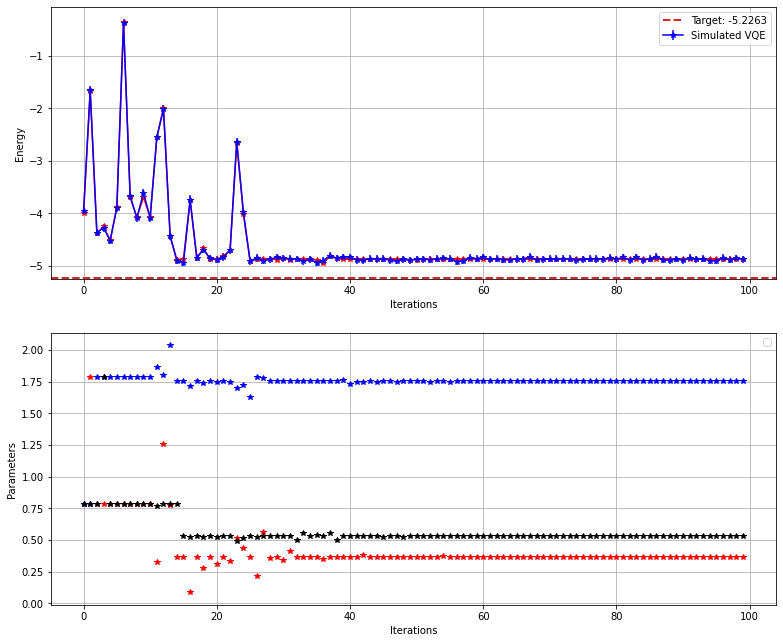

In [38]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)
# Define instance of qiskit-terra's Estimator primitive
estimator = Sampler()


# Setup VQE algorithm
custom_vqe = Miti_CustomVQE(estimator,ansatz,cobyla,level_miti=0,callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [26]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="c0df7c866f628346a4ad9eb0955b0b9e8ffedc7dc25fa33a87a59e50864c059fa00f211c7f611efee085a4b810646179209cc819b26a4903c733466bb8b96f51",overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = 'ibmq_belem'
noisy_backend = service.get_backend(backend)
backend_noise_model = NoiseModel.from_backend(noisy_backend)
simulator = service.get_backend('ibmq_qasm_simulator')
options = Options()
options.resilience_level = 0
options.optimization_level = 3
options.initial_layout=initial_layout
'''
options.simulator = {
    "noise_model": backend_noise_model
}
'''
options.shots=10000

In [27]:
# Define a simple callback function
intermediate_info_real_backend_0= []
def callback(value):
        intermediate_info_real_backend_0.append(value)



# Define a simple callback function

start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=0,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')



KeyboardInterrupt: ignored

In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_0:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_1= []
def callback(value):
        intermediate_info_real_backend_1.append(value)



# Define a simple callback function

start = time()
with Session(service=service, backend=simulator) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=1,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_1:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_2= []
def callback(value):
        intermediate_info_real_backend_2.append(value)

start = time()
with Session(service=service, backend=simulator) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=2,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_2:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_3= []
def callback(value):
        intermediate_info_real_backend_3.append(value)

start = time()
with Session(service=service, backend=simulator) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=3,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_3:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_4= []
def callback(value):
        intermediate_info_real_backend_4.append(value)

start = time()
with Session(service=service, backend=simulator) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=4,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')


In [ ]:
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info_real_backend_4:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_raw= []
def callback(value):
        intermediate_info_real_backend_raw.append(value)



# Define a simple callback function
simulator = service.get_backend('ibmq_qasm_simulator')
options = Options()
options.resilience_level = 0
options.optimization_level = 3
options.initial_layout=initial_layout
options.simulator = {
    "noise_model": backend_noise_model
}
options.shots=10000
start = time()
with Session(service=service, backend=simulator) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameters=[]
ideal_energy=[]
for data in intermediate_info_real_backend_raw:
  energies_miti.append(data[0])
  ideal_energy.append(data[1])
  parameters.append(list(data[2]))

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_meas= []
def callback(value):
        intermediate_info_real_backend_meas.append(value)



# Define a simple callback function
simulator = service.get_backend('ibmq_qasm_simulator')
options = Options()
options.resilience_level = 1
options.optimization_level = 3
options.initial_layout=initial_layout
options.simulator = {
    "noise_model": backend_noise_model
}
options.shots=10000
start = time()
with Session(service=service, backend=simulator) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameters=[]
ideal_energy=[]
for data in intermediate_info_real_backend_meas:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_zne= []
def callback(value):
        intermediate_info_real_backend_zne.append(value)



# Define a simple callback function
simulator = service.get_backend('ibmq_qasm_simulator')
options = Options()
options.resilience_level = 2
options.optimization_level = 3
options.initial_layout=initial_layout
options.simulator = {
    "noise_model": backend_noise_model
}
options.shots=10000
start = time()
with Session(service=service, backend=simulator) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameters=[]
ideal_energy=[]
for data in intermediate_info_real_backend_zne:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_PEC= []
def callback(value):
        intermediate_info_real_backend_PEC.append(value)



# Define a simple callback function
simulator = service.get_backend('ibmq_qasm_simulator')
options = Options()
options.resilience_level = 3
options.optimization_level = 3
options.initial_layout=[1,2]
options.simulator = {
    "noise_model": backend_noise_model
}
options.shots=10000
start = time()
with Session(service=service, backend=simulator) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = CustomVQE(rt_estimator,ansatz,cobyla,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(Ising_PBC_dual(g,h))
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
parameteres=[]
ideal_energy=[]
for data in intermediate_info_real_backend_zne:
  energies_miti.append(data[0])
  parameters.append(list(data[2]))
  ideal_energy.append(data[1])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.plot(energies_miti,color='blue',marker='*')
plt.plot(ideal_energy,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy_ising, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_ising))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
print(parameters)
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()